In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import os
import bs4
import requests

from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm

In [275]:
# colors from Tableau Colorblind 10
tableau_colorblind10 = [
    '#5f9ed1',
    '#006ba4',
    '#595959',
    '#898989',
    '#a2c8ac',
    '#ababab',
    '#c85200',
    '#cfcfcf',
    '#ff800e',
    '#ffbc79'
]

colors = {
    'background': tableau_colorblind10[2],
    'text': 'white',
    'fill': tableau_colorblind10[0]
}

style = {"axes.grid" : True,
         "axes.grid.axis" : "x",
         "axes.spines.top"  : False,
         "axes.spines.right"  : False,
         "axes.facecolor" : colors['background'],
         "figure.facecolor": colors['background'],
         "savefig.facecolor" : colors['background'],
         "grid.color" : colors['background'],
         "axes.edgecolor" : colors['text'],
         "text.color" : colors['text'],
         "xtick.color" : colors['text'],
         "ytick.color" : colors['text'],
         "ytick.left" : False,
         "xtick.bottom" : False,
         "font.size" : 14,
         }
plt.rcParams.update(style)

In [ ]:
# first we get our web data
# saved from https://aqiu384.github.io/megaten-fusion-tool/p5r/personas on 2020/06/28
with open('list-of-personas.html') as f:
    personas_html = f.read()

In [ ]:
# soupify
persona_soup = bs4.BeautifulSoup(personas_html, "html.parser")
table_raw = persona_soup.find('app-demon-list-container')
header, contents = table_raw.find_all('table')

In [ ]:
content_rows = contents.find('tbody').find_all('tr')
header_values = str.split("Arcana Lvl Name Inherits St Ma En Ag Lu Phys Gun Fire Ice Elec Wind Psi Nuke Bless Curse")

In [ ]:
def get_data_from_tr(tr):
    entries = tr.find_all('td')
    row = {}
    for value, entry in zip(header_values, entries):
        row[value] = str.strip(entry.text)
    return row

persona_dict = {get_data_from_tr(tr)["Name"]: get_data_from_tr(tr) for tr in content_rows}
persona_dict["Pixie"]

In [ ]:
personas = list(persona_dict.keys())
personas.sort(key=lambda name: persona_dict[name]['Lvl'])
for i, key in enumerate(personas):
    print(i,"\t", key)

In [218]:
compendium = pd.DataFrame(persona_dict.values())
compendium.sort_values(by=['Lvl', 'Arcana'], inplace=True)
compendium.replace({'rs':0.5, 'wk':2, 'no':'', 'nu':0, 'rp':-1}, inplace=True)
compendium.head()

,Arcana,Lvl,Name,Inherits,St,Ma,En,Ag,Lu,Phys,Gun,Fire,Ice,Elec,Wind,Psi,Nuke,Bless,Curse
13,Fool,1,Arsene,curse,2,2,2,3,1,,,,2,,,,,2,0.5
25,Magician P,1,Zorro,wind,2,3,1,3,1,,,,,2,0.5,,,,
80,Chariot,10,Slime,curse,9,6,11,6,5,0.5,0.5,2,,,2,,,,
54,Emperor,10,Regent,almighty,10,10,10,10,10,0.5,0.5,,,,,,2,,
22,Magician,11,Jack Frost,ice,8,9,7,9,7,,,2,0,,,,,,


In [219]:
compendium.to_csv("compendium-nosrc.csv") # compendium without cultural source

In [222]:
def format_name_for_site(persona_name):
    cut_dashes = persona_name.replace("-", " ")
    indiv_words = cut_dashes.split(" ")
    return "_".join(indiv_words)
format_name_for_site("Emperor's Amulet")

"Emperor's_Amulet"

<!DOCTYPE html>

<html class="" dir="ltr" lang="en">
<head>
<meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
<meta content="width=device-width, user-scalable=yes" name="viewport"/>
<meta content="MediaWiki 1.19.24" name="generator">
<meta content="Megami Tensei Wiki,megamitensei,Jack Frost,English Mythology,European Mythology,Megami Tensei II,Yoma,Fairy,Genma,Magica,Lovers Arcana,Magician Arcana,Persona 3" name="keywords">
<meta content="Jack Frost, sometimes known as Jack, is a demon in the series. Jack Frost is a spirit originating from England. He is a snow elf who brings in cold weather during the winter and is thought to be responsible for the frost that forms on the windows of homes and buildings." name="description"/>
<meta content="summary" name="twitter:card"/>
<meta content="@getfandom" name="twitter:site"/>
<meta content="https://megamitensei.fandom.com/wiki/Jack_Frost" name="twitter:url"/>
<meta content="Jack Frost | Megami Tensei Wiki | Fandom" name="tw
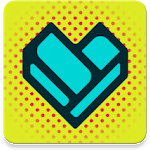
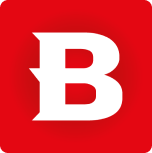

In [223]:
"""
base_site_name = "https://megamitensei.fandom.com/wiki/"
site_data = {}
for persona in compendium.Name:
    site = base_site_name + format_name_for_site(persona)
    pagereq = requests.get(site)
    site_data[persona] = bs4.BeautifulSoup(pagereq.text, "html.parser")
site_data["Jack Frost"]
"""

In [224]:
def extract_source(soup):
    try:
        return ", ".join([a.text for a in soup.find("div", attrs={"data-source":"origin"}).find("div").find_all("a")])
    except:
        return "Not Found"
extract_source(site_data["Arsene"]), extract_source(site_data["Jack Frost"]), extract_source(site_data["Pixie"])

('Modern Fiction',
 'English Mythology, European Mythology',
 'English Mythology')

In [225]:
sources = pd.DataFrame([{'Name':persona, 'Source':extract_source(site_data[persona])} for persona in compendium.Name])
sources.head()

,Name,Source
0,Arsene,Modern Fiction
1,Obariyon,Japanese Mythology
2,High Pixie,English Mythology
3,Izanagi,Japanese Mythology
4,Izanagi Picaro,Japanese Mythology


In [226]:
sources.groupby("Source").count()

,Name
Source,
Abrahamic Mythology,28
"Abrahamic Mythology, Canaanite Mythology, Semitic Mythology",1
"Abrahamic Mythology, European Mythology",1
"Abrahamic Mythology, Gnostic Mythology",2
"Abrahamic Mythology, Goetia Demons",2
...,...
Slavic artifact,1
South American Mythology,1
"Sri Lankan Mythology, Buddhist Mythology",1


In [ ]:
# NOTE TO SELF: DATASET EXCLUDES SOME DLC THINGS AND TIER 2/3 PARTY PERSONAS

In [229]:
arcana_numbers = {
    'Fool': 0,
    'Magician': 1,
    'Priestess': 2,
    'Empress': 3,
    'Emperor': 4,
    'Hierophant': 5,
    'Lovers': 6,
    'Chariot': 7,
    'Justice': 8,
    'Hermit': 9,
    'Fortune': 10,
    'Strength': 11,
    'Hanged': 12,
    'Death': 13,
    'Temperance': 14,
    'Devil': 15,
    'Tower': 16,
    'Star': 17,
    'Moon': 18,
    'Sun': 19,
    'Judgement': 20,
    'Faith': 21,
    'Councillor': 22,
    'World': 23
}

In [230]:
compendium = pd.read_csv("persona-compendium.csv")
compendium.fillna("", inplace=True)
compendium['Arcana_Number'] = compendium.Arcana.replace(arcana_numbers)
compendium = compendium.sort_values(by=['Arcana_Number', 'Lvl', 'Name']).reset_index()
column_reorder = str.split("Arcana_Number Arcana Lvl Name Inherits St Ma En Ag Lu Phys Gun Fire Ice Elec Wind Psi Nuke Bless Curse Region Type")
compendium = compendium[column_reorder]
compendium.head()

,Arcana_Number,Arcana,Lvl,Name,Inherits,St,Ma,En,Ag,Lu,...,Fire,Ice,Elec,Wind,Psi,Nuke,Bless,Curse,Region,Type
0,0,Fool,1,Arsene,curse,2,2,2,3,1,...,,2,,,,,2,0.5,FR,LIT
1,0,Fool,8,Obariyon,phys,7,3,9,8,4,...,,,2,,,,,,JP,MYTH
2,0,Fool,16,High Pixie,healing,8,14,10,13,10,...,,,0.5,0.5,,2,,,UK,MYTH
3,0,Fool,20,Izanagi,almighty,14,13,13,14,13,...,,,0.5,2,,,,0,JP,MYTH
4,0,Fool,23,Izanagi Picaro,almighty,16,15,15,16,14,...,,,0,2,,,,0,JP,MYTH


In [231]:
compendium.groupby("Region").count().max(axis=1)

Region
AB    35
AR     1
AU     2
BH     7
CH     8
EG     5
EU     6
FR     4
GO    10
GR    26
HA     1
HI    24
ID     2
IR     6
JP    45
MS     4
NM     2
NO     9
P5     9
SL     1
SP     1
UK    16
US     8
ZA     3
dtype: int64

In [235]:
compendium[compendium.Region == 'SL']

,Arcana_Number,Arcana,Lvl,Name,Inherits,St,Ma,En,Ag,Lu,...,Fire,Ice,Elec,Wind,Psi,Nuke,Bless,Curse,Region,Type
146,13,Death,62,Chernobog,ailment,40,37,39,38,39,...,2,ab,0,,,,2,ab,SL,MYTH


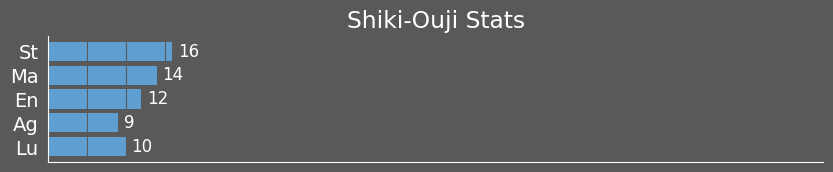

In [277]:
"""
Let's get a visual representation of persona stats going.
"""

STATS = str.split('St Ma En Ag Lu')
get_stats = lambda row: row[STATS]
lookup = lambda persona: compendium.loc[compendium.Name == persona].iloc[0]

def plot_stats(row):
    stats = get_stats(row)
    val = list(stats)
    lbl = list(stats.index)
    lbl.reverse()
    val.reverse()
    title = row.Name + " Stats"
    fig, ax = plt.subplots(figsize=(10, 2), dpi=100)
    plt.title(title)
    #fig.tight_layout()
    fig.subplots_adjust(bottom=0.25)
    ax.set_xlim(0, 100)
    plt.xticks(range(0, 100, 5), labels=[])
    plt.barh(lbl, val, color=colors['fill'])
    for i,j in zip(lbl, val):
        ax.annotate(j, xy=(j,i), xytext=(4, 0),textcoords='offset points', va="center", size=12)
    plt.show()

plot_stats(lookup("Shiki-Ouji"))

In [237]:
def stat_data(persona):
    stats = get_stats(lookup(persona))
    avg, std = stats.mean(), stats.std()
    outlier_cutoff = stats.median()*1.1 #stats.mean() + (stats.std() * 2) 
    outliers = stats[stats > outlier_cutoff]
    return persona, avg, std, outliers 
stat_data('Shiki-Ouji')

('Shiki-Ouji',
 12.2,
 2.8635642126552705,
 St    16
 Ma    14
 Name: 76, dtype: object)

In [238]:
"""
Now to make our stat cats! We want to decide on some number of archetypes and how to classify them.
Ex: Phys Bruiser would have St + Agi, balanced would have all stats near the same.
Perhaps even more broad cats? Like balanced vs 1 high vs 2 high? We can likely do both.
"""
get_num_outliers = lambda persona: len(stat_data(persona)[3])
get_num_outliers('Shiki-Ouji')
outliers = compendium.Name.apply(get_num_outliers)
compendium['Outliers'] = outliers
compendium

,Arcana_Number,Arcana,Lvl,Name,Inherits,St,Ma,En,Ag,Lu,...,Ice,Elec,Wind,Psi,Nuke,Bless,Curse,Region,Type,Outliers
0,0,Fool,1,Arsene,curse,2,2,2,3,1,...,2,,,,,2,0.5,FR,LIT,1
1,0,Fool,8,Obariyon,phys,7,3,9,8,4,...,,2,,,,,,JP,MYTH,2
2,0,Fool,16,High Pixie,healing,8,14,10,13,10,...,,0.5,0.5,,2,,,UK,MYTH,2
3,0,Fool,20,Izanagi,almighty,14,13,13,14,13,...,,0.5,2,,,,0,JP,MYTH,0
4,0,Fool,23,Izanagi Picaro,almighty,16,15,15,16,14,...,,0,2,,,,0,JP,MYTH,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,22,Councillor,44,Ananta,nuke,26,30,31,27,25,...,ab,2,,,,,,HI,MYTH,2
231,22,Councillor,57,Yatagarasu,fire,35,41,30,40,32,...,,,0.5,,,0,2,JP,MYTH,2
232,22,Councillor,62,Seiryu,ice,38,41,43,37,34,...,0.5,,,,2,,,CH,MYTH,1
233,22,Councillor,71,Dionysus,ailment,42,48,44,42,44,...,,-1,,,,0,0,GR,MYTH,0


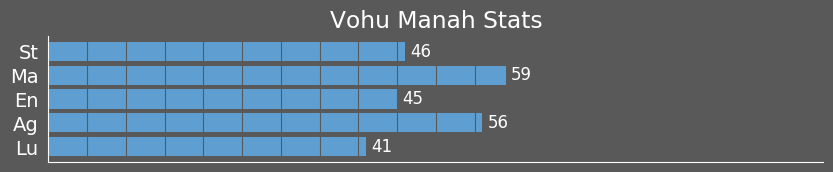

2

In [278]:
query = 'Vohu Manah'
plot_stats(lookup(query))
get_num_outliers(query)

In [240]:
# We want some minimum value for an adequate sample.
MIN_SIZE = 5
counts = compendium.groupby("Region").count().max(axis=1)
selected_counts = counts[counts >= MIN_SIZE]
target_regions = list(selected_counts.index)
target_regions

['AB',
 'BH',
 'CH',
 'EG',
 'EU',
 'GO',
 'GR',
 'HI',
 'IR',
 'JP',
 'NO',
 'P5',
 'UK',
 'US']

In [241]:
# compendium with only regions with MIN_SIZE or more elements
cut_compendium = compendium[compendium.Region.isin(target_regions)]
print("Percentage of personas kept:", len(cut_compendium) / len(compendium))
cut_compendium.head()

Percentage of personas kept: 0.9106382978723404


,Arcana_Number,Arcana,Lvl,Name,Inherits,St,Ma,En,Ag,Lu,...,Ice,Elec,Wind,Psi,Nuke,Bless,Curse,Region,Type,Outliers
1,0,Fool,8,Obariyon,phys,7,3,9,8,4,...,,2,,,,,,JP,MYTH,2
2,0,Fool,16,High Pixie,healing,8,14,10,13,10,...,,0.5,0.5,,2,,,UK,MYTH,2
3,0,Fool,20,Izanagi,almighty,14,13,13,14,13,...,,0.5,2,,,,0,JP,MYTH,0
4,0,Fool,23,Izanagi Picaro,almighty,16,15,15,16,14,...,,0,2,,,,0,JP,MYTH,0
5,0,Fool,26,Orpheus,almighty,17,17,17,17,17,...,,2,,,,0.5,2,GR,MYTH,0


In [242]:
cut_compendium.groupby("Region")["Outliers"].aggregate(["count", "mean", "std"])

,count,mean,std
Region,,,
AB,35,0.885714,0.795998
BH,7,1.285714,0.487950
CH,8,0.875000,0.640870
EG,5,0.800000,0.836660
EU,6,1.500000,0.836660
GO,10,1.000000,0.816497
GR,26,1.115385,0.816182
HI,24,1.083333,0.880547
IR,6,1.333333,0.816497


In [243]:
eda = cut_compendium.groupby("Region")["Outliers"].aggregate(["count", "mean", "std"])
(eda["mean"].max() - eda["mean"].drop('P5').min()), (eda["std"].max() - eda["std"].drop('P5').min())

(0.7, 0.39259656583624125)

In [ ]:
# try again with larger groups, for bigger sample size
# We want some minimum value for an adequate sample.
MIN_SIZE = 10
counts = compendium.groupby("Region").count().max(axis=1)
selected_counts = counts[counts >= MIN_SIZE]
target_regions = list(selected_counts.index)
# compendium with only regions with MIN_SIZE or more elements
cut_compendium = compendium[compendium.Region.isin(target_regions)]
print("Percentage of personas kept:", len(cut_compendium) / len(compendium))
print(target_regions)
cut_compendium.head()

In [ ]:
cut_compendium.groupby("Region")["Outliers"].aggregate(["count", "mean", "std"])

In [ ]:
eda = cut_compendium.groupby("Region")["Outliers"].aggregate(["count", "mean", "std"])
(eda["mean"].max() - eda["mean"].min()), (eda["std"].max() - eda["std"].min())

In [244]:
#hmm... let's try type
compendium.groupby("Type").count().max(axis=1)

Type
HIST      7
LIT      11
MYTH    205
P5        9
POP       3
dtype: int64

In [245]:
#everything is from mythology. This would be something of a waste of time. Let's do it anyway
compendium.groupby("Type")["Outliers"].aggregate(["count", "mean", "std"])

,count,mean,std
Type,,,
HIST,7,1.571429,0.534522
LIT,11,1.363636,0.674200
MYTH,205,1.087805,0.793415
P5,9,0.000000,0.000000
POP,3,1.000000,1.000000


In [ ]:
# could be interesting, but sample sizes are wayyyyyyyy too low.

In [246]:
# Only one avenue left... Arcana?
compendium.groupby("Arcana")["Outliers"].aggregate(["count", "mean", "std"])

,count,mean,std
Arcana,,,
Chariot,10,1.400000,0.966092
Councillor,8,1.125000,0.991031
Death,13,1.461538,0.776250
Devil,9,1.111111,0.600925
Emperor,10,0.800000,0.918937
Empress,10,0.900000,0.737865
Faith,10,1.200000,0.632456
Fool,14,0.714286,0.825420
Fortune,11,1.545455,0.687552


In [247]:
eda = compendium.groupby("Arcana")["Outliers"].aggregate(["count", "mean", "std"])
(eda["mean"].max() - eda["mean"].min()), (eda["std"].max() - eda["std"].min())

(0.9333333333333335, 0.49103120896511476)

In [248]:
# We could run an ANOVA - but there's so many groups and so few members per groups
# Maybe we could run a linear classifier? then use the coefficients to divine information

X = pd.get_dummies(compendium.Arcana)
y = compendium.Outliers
reg = LinearRegression().fit(X, y)

results = pd.DataFrame(zip(X.columns, reg.coef_), columns=["Arcana", "coeff"])
display(results)

,Arcana,coeff
0,Chariot,7.627935e+12
1,Councillor,7.627935e+12
2,Death,7.627935e+12
3,Devil,7.627935e+12
4,Emperor,7.627935e+12
5,Empress,7.627935e+12
6,Faith,7.627935e+12
7,Fool,7.627935e+12
8,Fortune,7.627935e+12
9,Hanged,7.627935e+12


In [249]:
# Uh, that's not right
# Try again, avoiding the dummy variable trap
X = pd.get_dummies(compendium.Arcana, drop_first=True)
y = compendium.Outliers
reg = LinearRegression().fit(X, y)

results = pd.DataFrame(zip(X.columns, reg.coef_), columns=["Arcana", "coeff"])
results = results.append({'Arcana':'Chariot', 'coeff': 0}, ignore_index=True).sort_values(by='coeff', ascending=False).reset_index(drop=True)
display(results)
reg.intercept_

,Arcana,coeff
0,Lovers,0.200000
1,Fortune,0.145455
2,Moon,0.061538
3,Death,0.061538
4,Chariot,0.000000
5,Faith,-0.200000
6,Hermit,-0.246154
7,Councillor,-0.275000
8,Devil,-0.288889
9,Star,-0.288889


1.4000000000000015

In [250]:
reg = sm.OLS(y, sm.add_constant(X))
reg = reg.fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Outliers   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     1.319
Date:                Wed, 30 Sep 2020   Prob (F-statistic):              0.161
Time:                        15:15:52   Log-Likelihood:                -265.44
No. Observations:                 235   AIC:                             576.9
Df Residuals:                     212   BIC:                             656.5
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4000      0.249      5.616      0.000       0.909       1.891
Councillor    -0.2750      0.374     -0.735      0.463      -1.012       0.462
Death          0.0615      0.332      0.186      0.853      -0.592       0.715
Devil         -0.2889      0.362     -0.798      0.426      -1.003       0.425
Emperor       -0.6000      0.353     -1.702      0.090      -1.295       0.095
Empress       -0.5000      0.353     -1.418      0.158      -1.195       0.195
Faith         -0.2000      0.353     -0.567      0.571      -0.895       0.495
Fool          -0.6857      0.326     -2.101      0.037      -1.329      -0.042
Fortune        0.1455      0.344      0.422      0.673      -0.533       0.824
Hanged        -0.4000      0.353     -1.135      0.258      -1.095       0.295
Hermit        -0.2462      0.332     -0.742      0.459      -0.900       0.407
Hierophant    -0.4000      0.388     -1.030      0.304      -1.166       0.366
Judgement     -0.7333      0.362     -2.025      0.044      -1.447      -0.019
Justice       -0.6727      0.344     -1.953      0.052      -1.352       0.006
Lovers         0.2000      0.353      0.567      0.571      -0.495       0.895
Magician      -0.4000      0.338     -1.185      0.237      -1.065       0.265
Moon           0.0615      0.332      0.186      0.853      -0.592       0.715
Priestess     -0.6000      0.353     -1.702      0.090      -1.295       0.095
Star          -0.2889      0.362     -0.798      0.426      -1.003       0.425
Strength      -0.5000      0.353     -1.418      0.158      -1.195       0.195
Sun           -0.5250      0.374     -1.404      0.162      -1.262       0.212
Temperance    -0.5111      0.362     -1.411      0.160      -1.225       0.203
Tower         -0.4000      0.362     -1.104      0.271      -1.114       0.314
==============================================================================
Omnibus:                       40.359   Durbin-Watson:                   1.893
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               10.445
Skew:                          -0.148   Prob(JB):                      0.00540
Kurtosis:                       2.010   Cond. No.                         24.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""